<h1>Introduction to Centrifuge</h1>

The Centrifuge toolkit leverages existing Python data science libraries to provide facilities for analyzing information in binary files. Prior to any analysis, files are split into blocks, usually 1024 bytes in size. Statistical measurements of each block are then taken, and these per-block measurements are stored in a data frame which is input to the DBSCAN clustering algorithm. The clusters discovered by DBSCAN have their data type determined by measuring the Wasserstein distance between the distribution of byte values of the data in the cluster and a number of data type reference distributions. In the event that a cluster is identified as containing machine code, the web API of Kairajärvi et. al.'s [ISAdetect](https://github.com/kairis/isadetect) is used to determine the target architecture.

Development of this toolkit was prompted by a desire to empirically study information in firmware files using visualization, statistical methods and machine learning techniques. Centrifuge is format-agnostic - it treats the bytes in a file as raw integer values without any interpretation and does not rely on any kind of metadata or information about how a file may be structured. As a result, it can be used to analyze any type of file containing information encoded in 8-bit bytes, not just files containing machine code.

In this notebook, Centrifuge's capabilities will be demonstrated by analyzing a well-known ELF binary, [bash](https://www.man7.org/linux/man-pages/man1/bash.1.html).

<h3>Contents:</h3>

 1. File Partitioning and Feature Engineering
 2. Information Visualization
 3. Clustering with DBSCAN
 4. Data Type Identification using Wasserstein Distance
 5. Machine Code Target Architecture Identification with Kairajärvi et. al.'s ISAdetect
 6. References
 
<hr>

<h1>1. File Partitioning and Feature Engineering</h1>

There are several approaches to analyzing information encoded in binary files. These include:

 - treating the entire file as a blob of bytes [1]
 - relying on metadata such as a file header or section header table to extract different types of information directly [2]
 - using a "sliding window" [3][4][5][6]
 - partitioning the file into same-sized pieces or blocks [7]
 
The last approach, partitioning a file into fized-sized blocks, is the one implemented by Centrifuge. This is based on the [method implemented in `binwalk` to measure and plot file entropy](https://github.com/ReFirmLabs/binwalk/blob/ff34b1219e9b34bcd47251f63ba99e12d01bfc74/src/binwalk/modules/entropy.py#L150). However, aside from entropy, Centrifuge measures an additional 6 features per block: 
 - mean
 - median
 - standard deviation
 - standard deviation of byte value frequencies/counts
 - proportion of bytes within printable ASCII range
 - proportion of bytes that are 0

None of the analyses performed by this toolkit would have been possible without these engineered features. Storing the feature measurements of each block in a data frame makes it straightforward to use statistical methods or machine learning algorithms to analyze the information encoded in a binary file.

<img src="https://raw.githubusercontent.com/BinaryResearch/centrifuge-toolkit/master/images/approach.png?token=AM7X623RDOQWM7OHUASHTW27ILJ7O" />

 - *Entropy* is Shannon entropy from information theory.
 - *Standard deviation of counts* is the standard deviation of the counts (frequencies) of the byte values in each block. The distribution of byte value frequencies is different from the distribution of byte values themselves and as a result provides additional information. 
 - *ASCII ratio* is the proportion of bytes in the printable ASCII range (0x20 - 0x7e). Use of this variable was based on use of [cortesi's](https://github.com/cortesi) [binvis.io](http://binvis.io/#/) as well as analysis of binary files via examination of hex dumps, in which it was observed that different types of information (e.g. machine code vs. hardcoded strings) had distinctly different proportions of printable ASCII bytes.
 - *0x00 ratio* is simply the proportion of bytes in a block that have a value of zero. This also varies based on the information encoding; blocks of compressed or encrypted data or text data have few 0x00 bytes, whereas blocks containing machine code will have more.
 
Together, these 7 features provide a way to measure and objectively quantify properties of the information stored in a binary file. Through analysis of these measurements it is possible to gain insights into how information in binary files is organized that would be more difficult to attain using other means of analysis. An example of one such insight is that it is possible to use unsupervised machine learning techniques (specifically, density-based clustering with DBSCAN) to distinguish between different types of information e.g. machine code versus non-machine code information.

<h1>2. Information Visualization</h1>

In [1]:
import sys
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]  # we want large, uniformly-sized plots

sys.path[0:0] = ['.', '..']               # the centrifuge library files are located in ../centrifuge

from centrifuge.binfile import BinFile

The first step is partitioning the file into blocks:

In [2]:
file_handle = open("/bin/bash", "rb")
bash = BinFile(file_handle)

bash.slice_file()

bash.file_data_frame

,entropy,zeroes ratios,ascii ratios,byte value std dev,byte value counts std dev,byte value mean,byte value median
0,4.019369,0.518555,0.000000,52.457772,33.232373,31.256836,0
1,6.104327,0.131836,0.227539,62.835930,10.752907,58.680664,32
2,5.202181,0.321289,0.104492,64.061118,21.307276,44.714844,12
3,2.453923,0.688477,0.157227,57.351300,44.634278,21.516602,0
4,2.600473,0.668945,0.166992,54.156374,43.376531,20.534180,0
...,...,...,...,...,...,...,...
1083,0.993393,0.812500,0.187500,32.494170,52.306787,12.437500,0
1084,1.617374,0.781250,0.125000,45.755069,50.077908,16.846680,0
1085,3.052655,0.616211,0.036133,52.084647,39.492483,33.143555,0
1086,1.865681,0.793945,0.000000,50.510790,50.716661,16.334961,0


As we can see from the above data frame, the file has been partitioned into 1088 blocks. Each row in the table represents a single block. [Exploratory data analysis (EDA)](https://www.itl.nist.gov/div898/handbook/eda/section1/eda11.htm) can now commence.

<h3>Information Visualization: File Entropy</h3>
    
At this point, it is already possible to visualize file data using traditional plots such as box plots or histograms, but it is not very useful to do so because the file contians many different types of information which are not differentiated from each other in the file data frame. As an example, below is a violin plot that shows the distribution of block entropy levels:

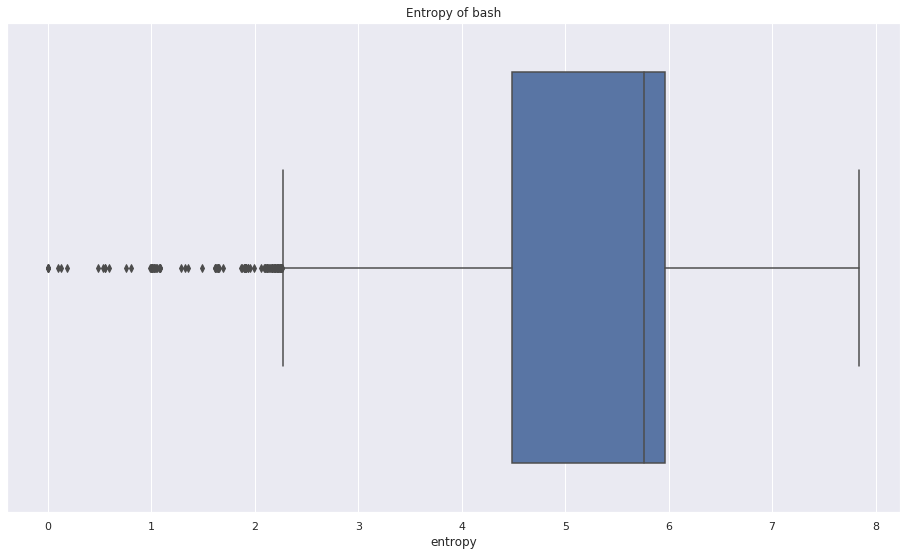

In [3]:
sns.boxplot(x="entropy", data=bash.file_data_frame)
plt.title("Entropy of bash")
plt.show()

It can be seen that entropy levels range from 0 to near the maximum possible, 8. Additionally, most blocks seem to have an entropy level between 4.5 and 6. This does not tell us much about what types of information may be encoded in the file other than there is some encrypted/compressed data. It is also not clear how information is organized within the file. 

At this stage, a much more useful visualization is a plot in which information about the location of a block within the file - its *offset* - is included:

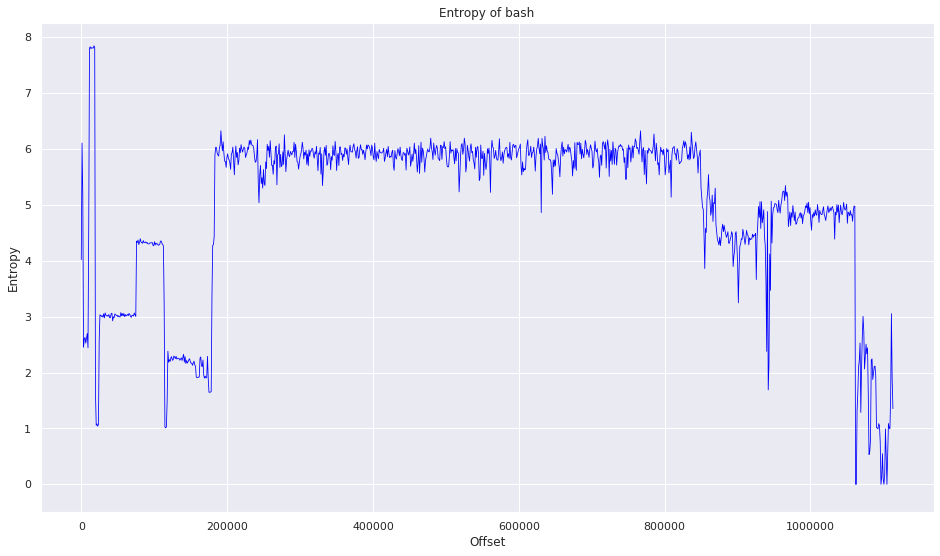

In [4]:
bash.plot_file_entropy()

Several contiguous regions of similar entropy level emerge. It turns out that these regions correspond to different [*sections*](https://docs.oracle.com/cd/E19120-01/open.solaris/819-0690/6n33n7fcb/index.html) of the binary. Though the information in each section has a distinct purpose, several sections may contain similar types of data. For example, the `.dynstr` and `.rodata` sections play different roles but both contain hard-coded ASCII strings.

One of the design goals of Centrifuge was to develop a way to accurately determine whether machine code is present in a binary file. In an ELF binary, the `.text` section will contain machine code. The exact location and size of the `.text` section in `bash` can be found using `readelf`:

```
$ readelf -SW /bin/bash
There are 28 section headers, starting at offset 0x10f6a0:

Section Headers:
  [Nr] Name              Type            Address          Off    Size   ES Flg Lk Inf Al
...
  [14] .text             PROGBITS        000000000002cbc0 02cbc0 0a2c02 00  AX  0   0 16
...
```

`Off` is the offset, the number of bytes into the file that the section begins at. This section can be demarcated on the entropy plot:

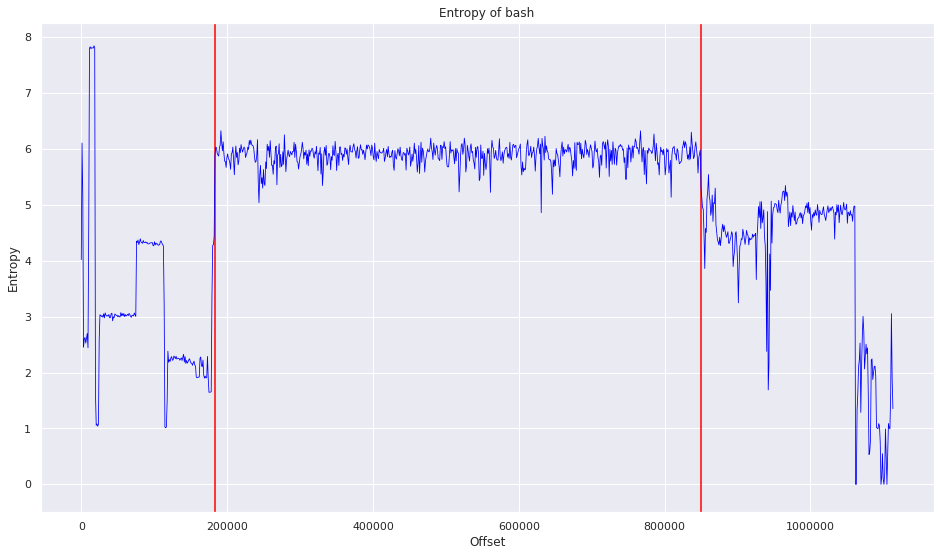

In [5]:
bash.plot_file_entropy(0x02cbc0, 0x02cbc0 + 0x0a2c02)

This highlights that in terms of entropy, machine code is distinct from other types of information in the binary.

The small bit of high-entropy data toward the beginning of the file belongs to the `.gnu.hash` section:

```
Section Headers:
  [Nr] Name              Type            Address          Off    Size   ES Flg Lk Inf Al
...
  [ 4] .gnu.hash         GNU_HASH        0000000000000298 000298 0049a8 00   A  5   0  8
...
```

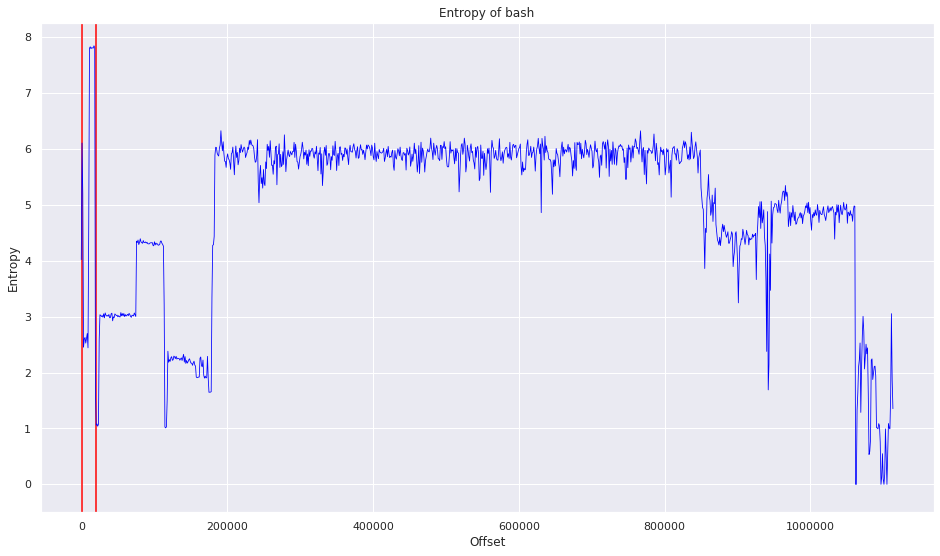

In [6]:
bash.plot_file_entropy(0x000298, 0x000298 + 0x0049a8)

Though the `.rodata` section contains ASCII strings, it is clearly less homogeneous in terms of entropy than the sections examined above:

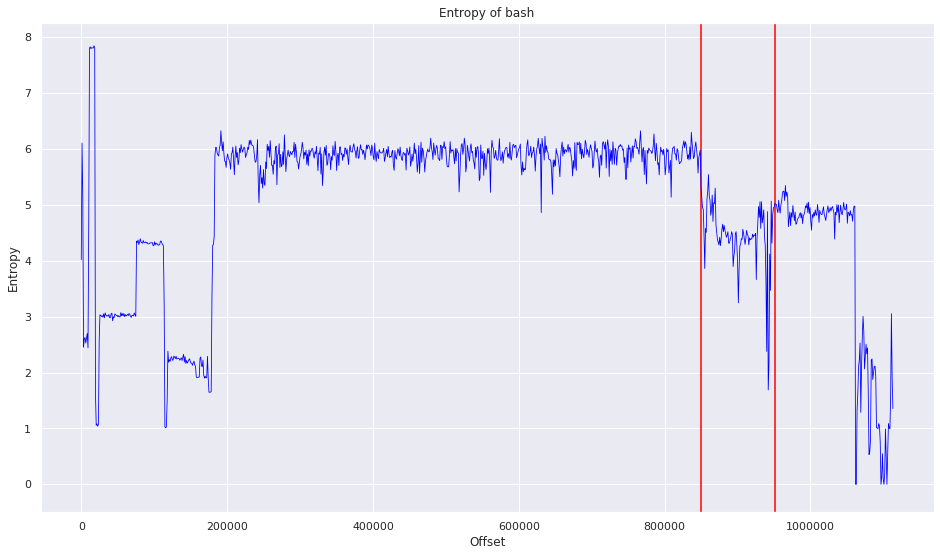

In [7]:
bash.plot_file_entropy(0x0cf7e0, 0x0cf7e0 + 0x018ec0)

For those who have used `binwalk` to plot file entropy, the plots above will look quite familiar. However, in addition to entropy it is possible to plot 6 other variables.

<h3>Information Visualization: Plotting Any Single Feature</h3>

It is possible to plot file mean, median, standard deviation, standard deviation of byte value frequencies/counts, proportion of bytes within printable ASCII range and proportion of bytes that are 0.

For reference, the plots below will all demarcate the `.text` section which contains machine code:

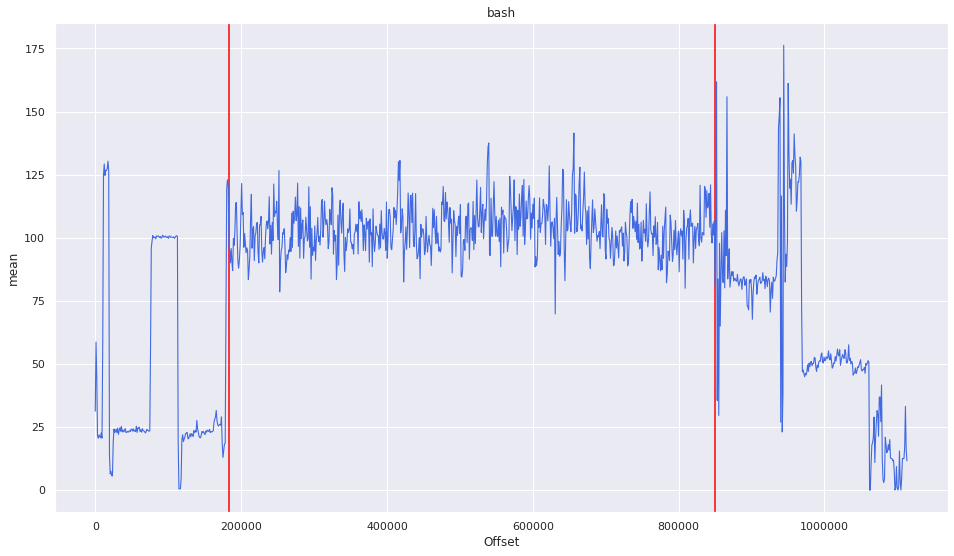

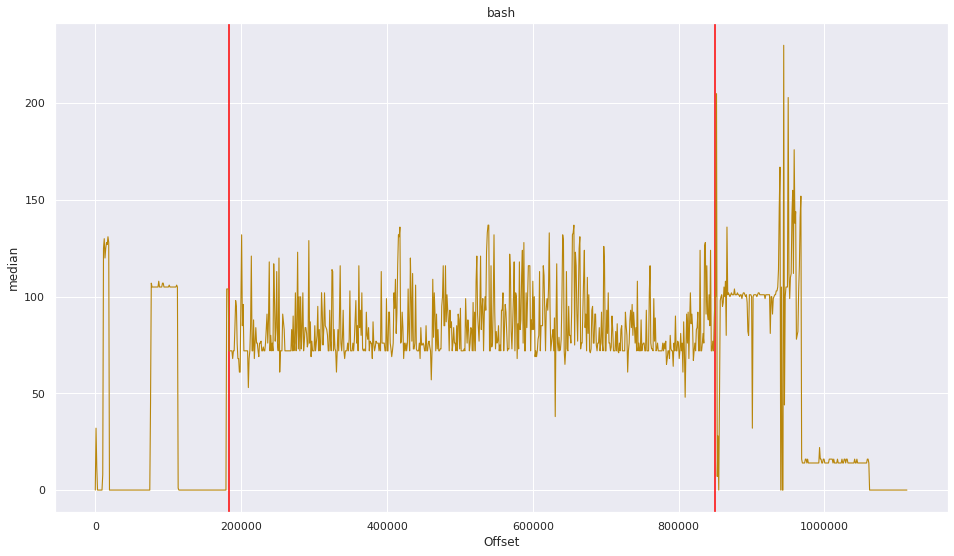

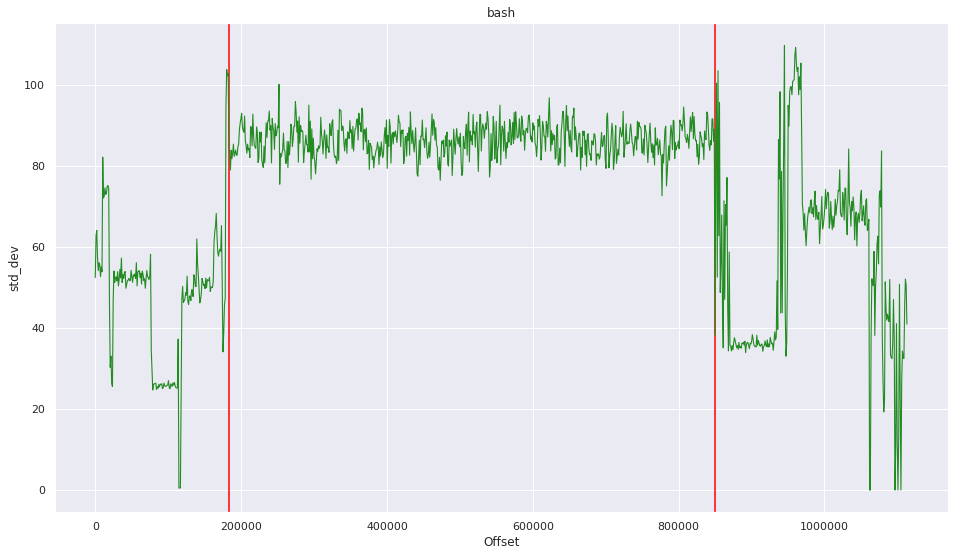

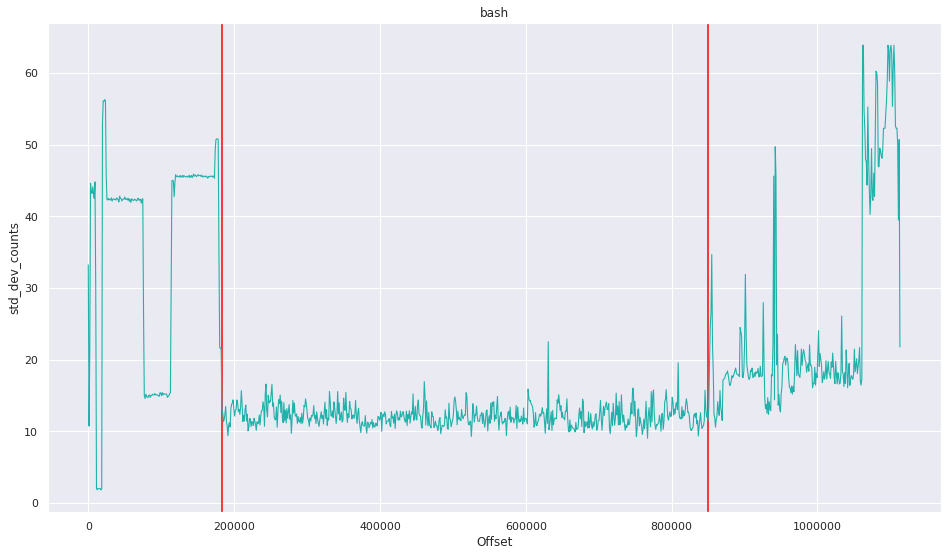

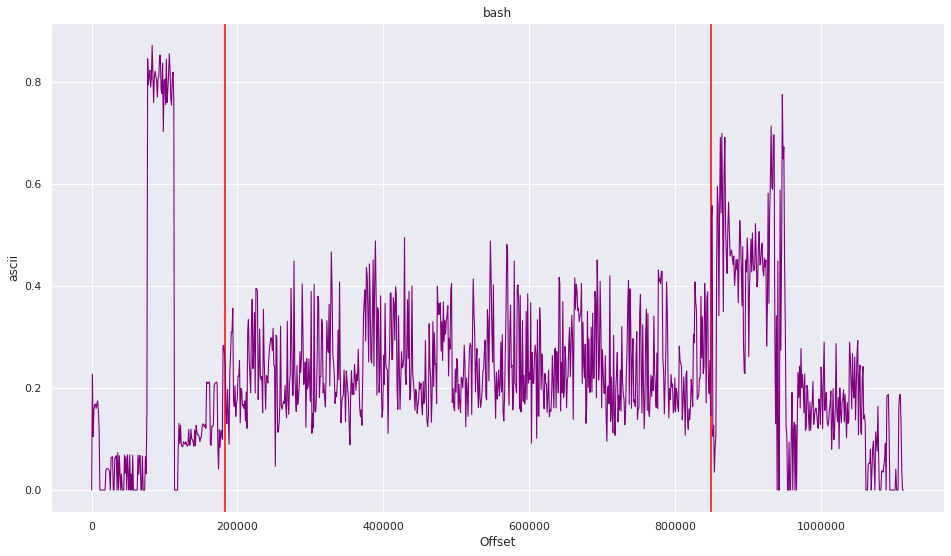

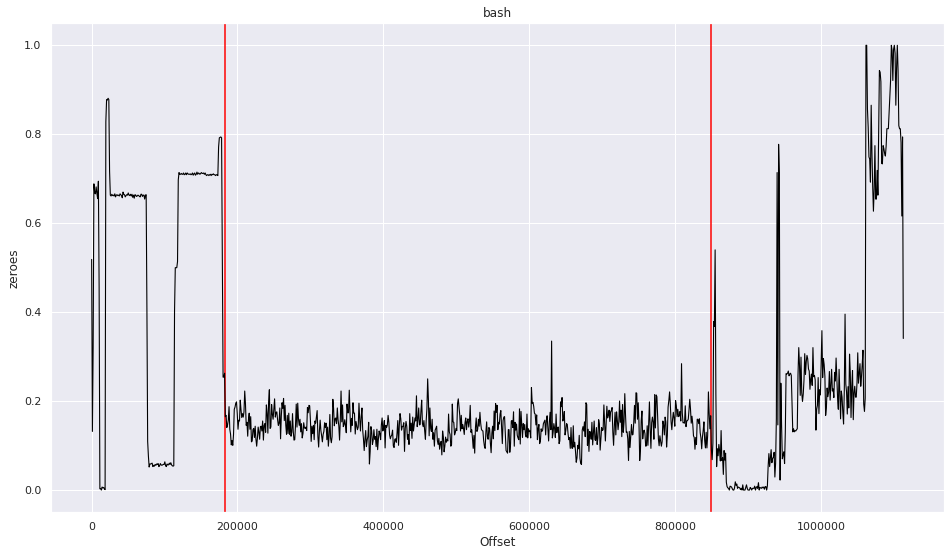

In [8]:
plot_features = {"mean": "royalblue",
                 "median": "darkgoldenrod",
                 "std_dev": "forestgreen",
                 "std_dev_counts": "lightseagreen",
                 "ascii": "purple",
                 "zeroes": "black"}

for feature, color in plot_features.items():
    bash.plot_file_feature(feature, color, 0x02cbc0, 0x02cbc0+0x0a2c02)

Judging by these plots, it appears that different types of data also have different statistical properties.

<h3>Information Visualization: 2D Scatterplots</h3>

A next natural step is moving from plotting a single variable to plotting 2 variables against each other. This can be done by either plotting columns from the file data frame using Matplotlib directly, or by using plotting functions that Centrifuge makes available.

Here is an example of plotting two data frame columns against each other using Matplotlib.pyplot:

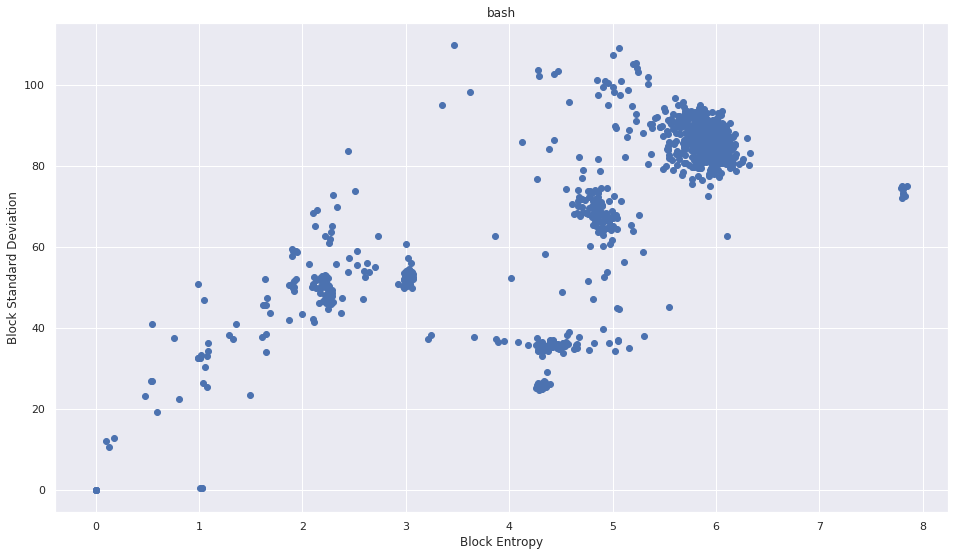

In [9]:
plt.scatter(bash.block_entropy_levels, 
            bash.block_byteval_std_dev)
plt.title("bash")
plt.xlabel("Block Entropy")
plt.ylabel("Block Standard Deviation")
plt.show()

Each point represents a block (a row in the data frame), so in this plot there are 1088 points. 

At least 7 clusters are immediately apparent. Perhaps these clusters are composed of different types of information? To investigate, Centrifuge can be used to color points in the scatterplot based on whether they fall within a particular area in the file. Points within the specified range will be one color, and points outside of this range will be a different color. To start, we can opt to color all points that fall within the `.text` section (the machine code) red, and all others black:

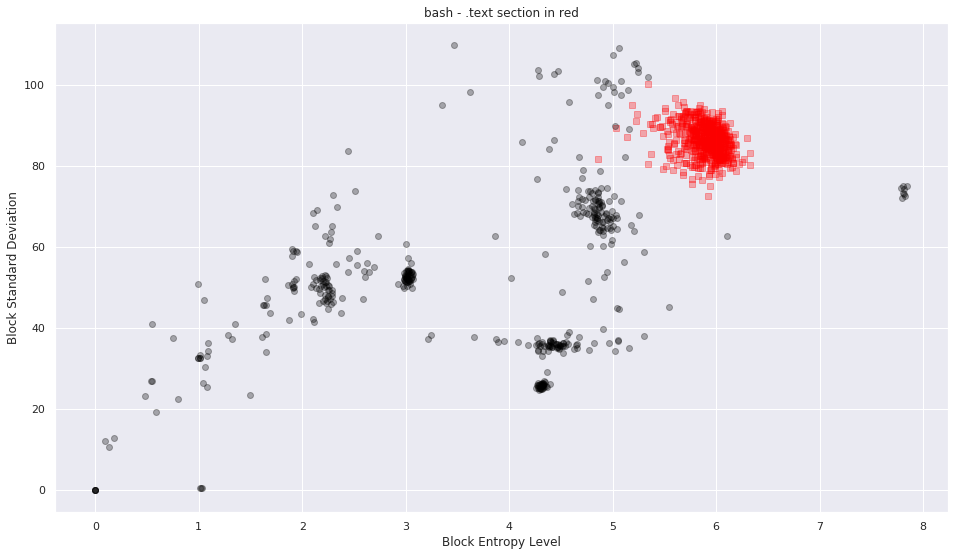

In [10]:
bash.plot_variables_by_range(bash.block_entropy_levels,      # x variable
                             bash.block_byteval_std_dev,     # y variable
                             0x02cbc0,                       # start file offset
                             0x02cbc0+0x0a2c02,              # end file offset
                             target_data_marker='s',         # marker shape for points that fall within the specified offsets
                             other_data_marker='o',          # marker for points outside of offsets
                             target_data_color='red',        # color of points inside offsets
                             other_data_color='black',       # color of points outside offsets
                             title='bash - .text section in red',   
                             xlabel='Block Entropy Level',
                             ylabel='Block Standard Deviation')

The same can be done for any other section or region within the file. For example, the points representin blocks falling within the `.rodata` section can be highlighted next:

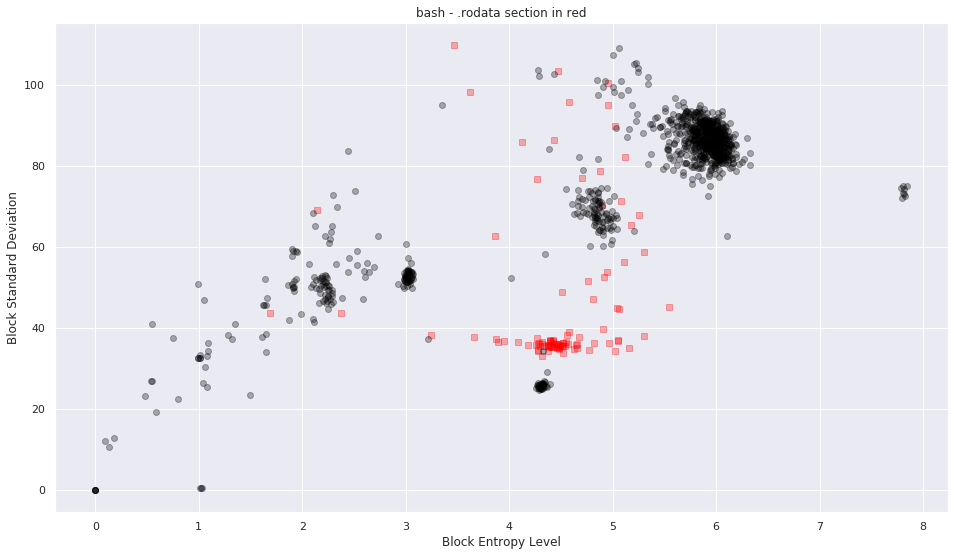

In [11]:
bash.plot_variables_by_range(bash.block_entropy_levels,      # x variable
                             bash.block_byteval_std_dev,     # y variable
                             0x0cf7e0,                       # start file offset
                             0x0cf7e0 + 0x018ec0,            # end file offset
                             target_data_marker='s',         # marker shape for points that fall within the specified offsets
                             other_data_marker='o',          # marker for points outside of offsets
                             target_data_color='red',        # color of points inside offsets
                             other_data_color='black',       # color of points outside offsets
                             title='bash - .rodata section in red',   
                             xlabel='Block Entropy Level',
                             ylabel='Block Standard Deviation')

In addition to the cluster centered at (4.4, 38), there are red points scattered about. These results suggest that in addition to a single data type, other more heterogeneous information is encoded in the `.rodata` section.

Just for fun, let us examine the `.eh_frame` section, and also change some of the options:

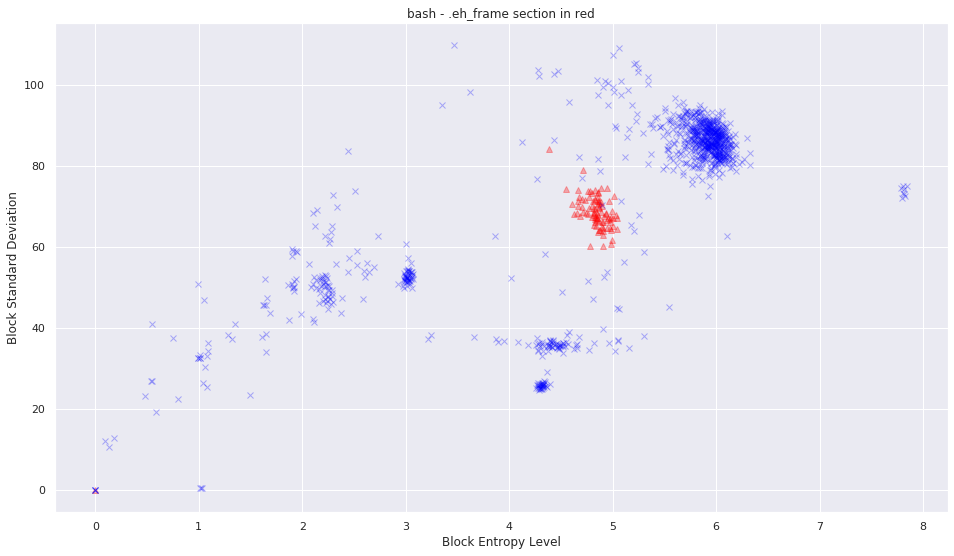

In [12]:
bash.plot_variables_by_range(bash.block_entropy_levels,      # x variable
                             bash.block_byteval_std_dev,     # y variable
                             0x0ec958,                       # start file offset
                             0x0ec958 + 0x016ab0,            # end file offset
                             target_data_marker='^',         # marker shape for points that fall within the specified offsets
                             other_data_marker='x',          # marker for points outside of offsets
                             target_data_color='red',        # color of points inside offsets
                             other_data_color='blue',        # color of points outside offsets
                             title='bash - .eh_frame section in red',   
                             xlabel='Block Entropy Level',
                             ylabel='Block Standard Deviation')

Clusters are also apparent when other features are chosen. For example, instead of plotting entropy vs. standard deviation, we can plot block means vs. their proportion of 0x00 bytes (points within `.text` section are orange): 

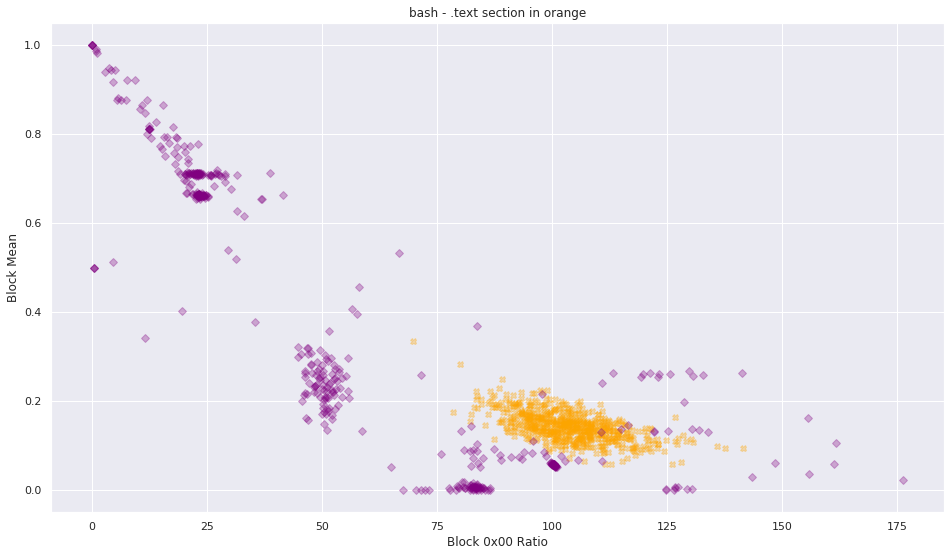

In [13]:
bash.plot_variables_by_range(bash.block_byteval_mean,        # x variable
                             bash.block_zeroes_ratios,       # y variable
                             0x02cbc0,                       # start file offset
                             0x02cbc0+0x0a2c02,              # end file offset
                             target_data_marker='X',         # marker shape for points that fall within the specified offsets
                             other_data_marker='D',          # marker for points outside of offsets
                             target_data_color='orange',        # color of points inside offsets
                             other_data_color='purple',       # color of points outside offsets
                             title='bash - .text section in orange',   
                             xlabel='Block 0x00 Ratio',
                             ylabel='Block Mean')

It is very clear from these visualizations that clusters form in 2-dimensional space when different features are plotted against each other. A logical next step is investigating whether a clustering algorithm can  discover clusters in higher dimensional space (in this case 7-dimensional space).

<h1>3. Clustering with DBSCAN</h1>

If a file is sufficiently large, DBSCAN is capable of identifying statistically distinct regions within a file:

<img src="https://raw.githubusercontent.com/BinaryResearch/centrifuge-toolkit/master/images/approach_2.png?token=AM7X62Z7KP3CABXDDMFIT427ILKBO" />


DBSCAN was chosen over other algorithms such as K-means due to the fact that the number of clusters in a file cannot be known beforehand, as well as the fact that clusters can be any shape.

>The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples). There are two parameters to the algorithm, `min_samples` and `eps`, which define formally what we mean when we say dense. Higher `min_samples` or lower `eps` indicate higher density necessary to form a cluster. [8]

The two main "dials" that must be adjusted for optimal results are `eps` and `min_samples`:

>**eps: float, default=0.5**
>
>The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function. [9]


>**min_samples: int, default=5**
>
>The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself. [9]

Here are the results of using DBSCAN to find clusters in `bash`:

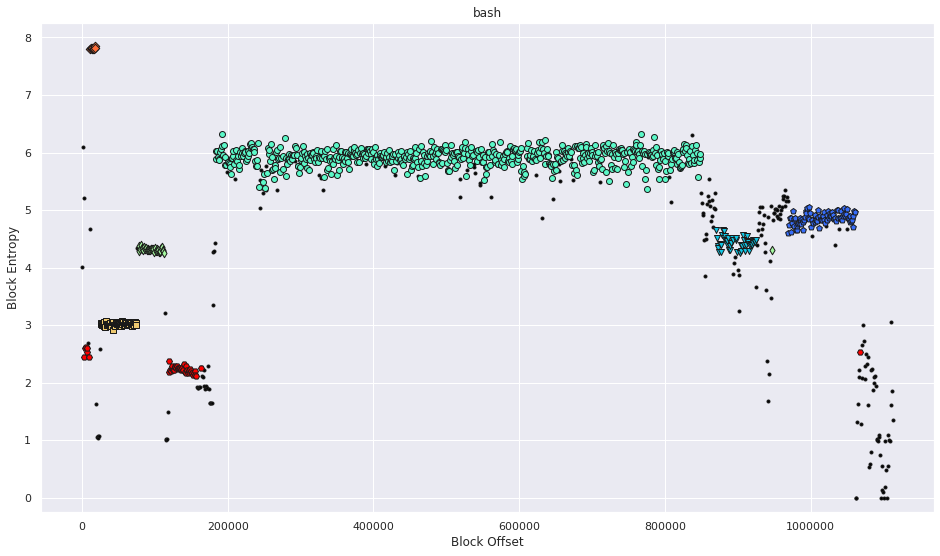

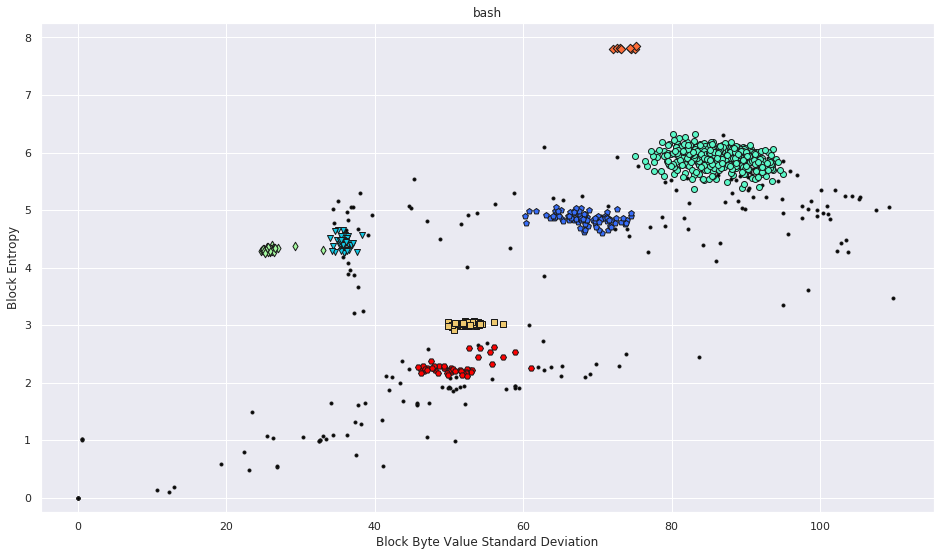

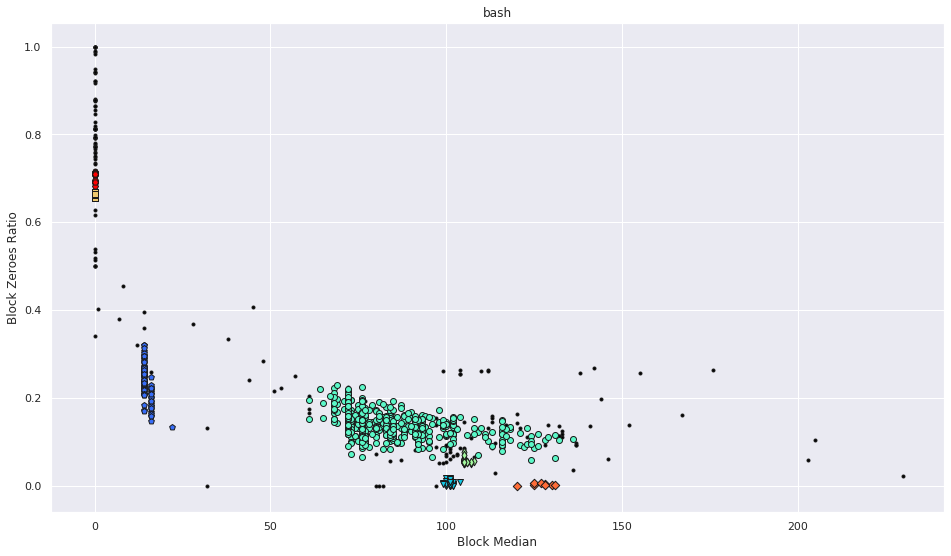

In [14]:
bash.cluster_DBSCAN(epsilon=0.3,      
                    minimum_samples=8,
                    find_optimal_epsilon=False)    # don't show "knee" plot here

bash.plot_DBSCAN_results()

For these values of `eps` and `min_samples`, DBSCAN identifies 7 clusters. In addition to the plots above, the results of clustering can also be viewed with a scatterplot matrix that colors points based on their cluster label (the points not assigned to any cluster have been removed):

/home/user01/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/user01/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


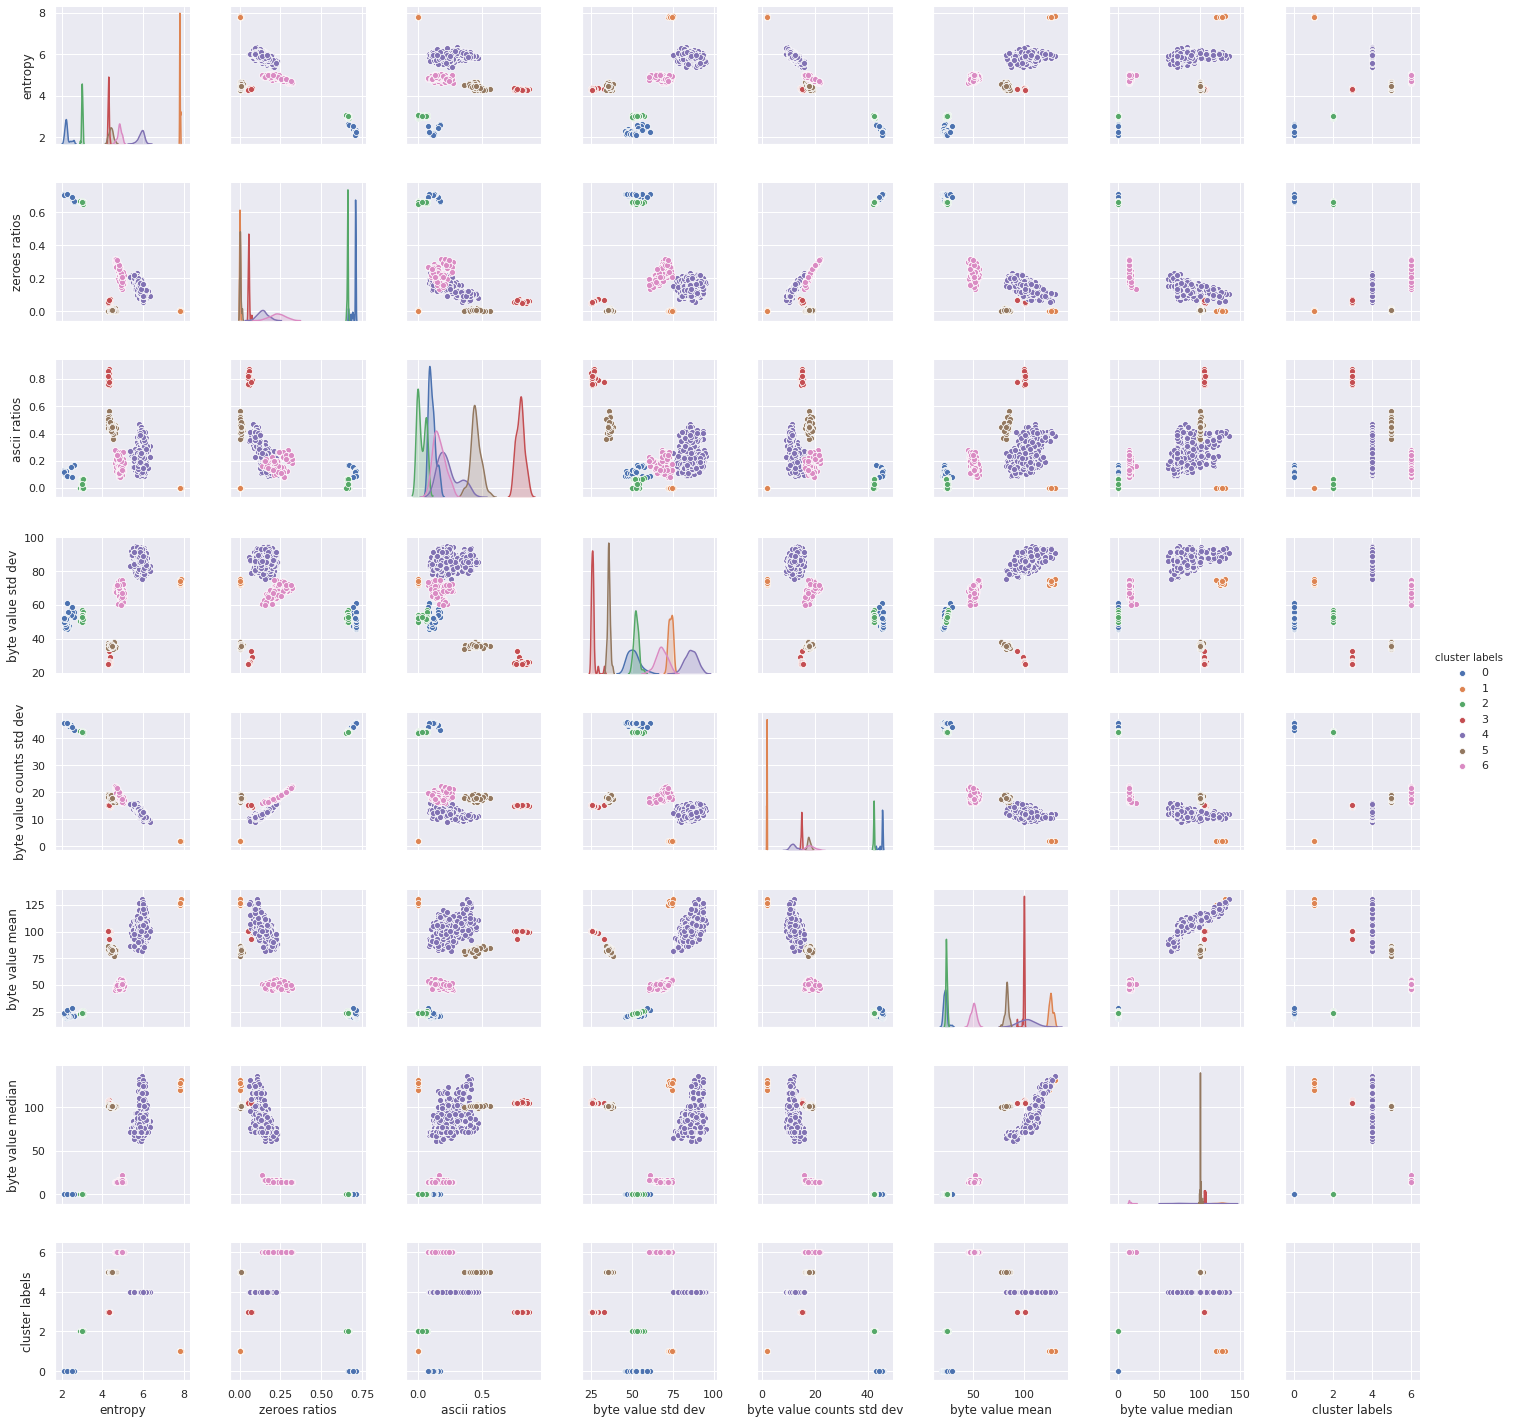

In [15]:
bash.cluster_scatterplot_matrix()

Any of the 2D plots in the scatterplot matrix above can be plotted individually:

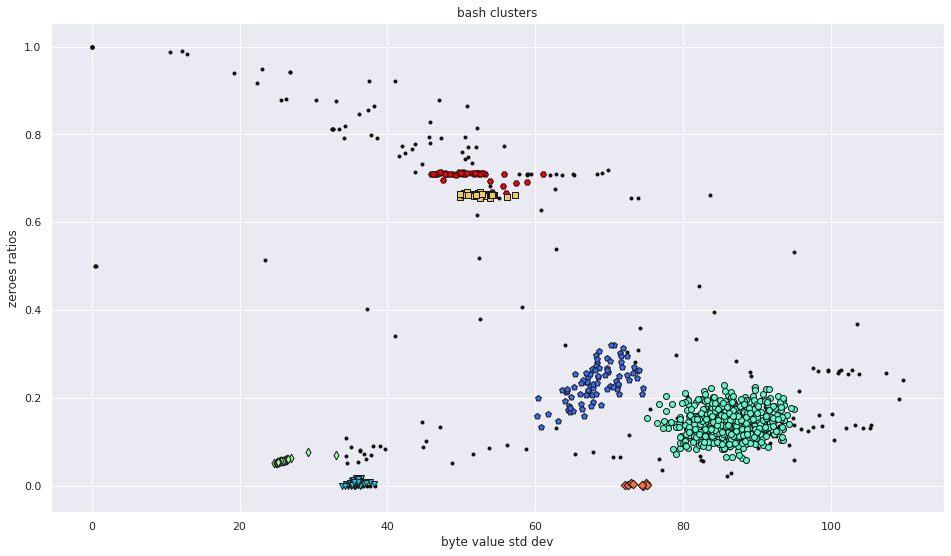

In [16]:
bash.plot_two_features_with_cluster_labels("byte value std dev", "zeroes ratios")

If points not assigned a cluster label are undesirable, they can be dropped:

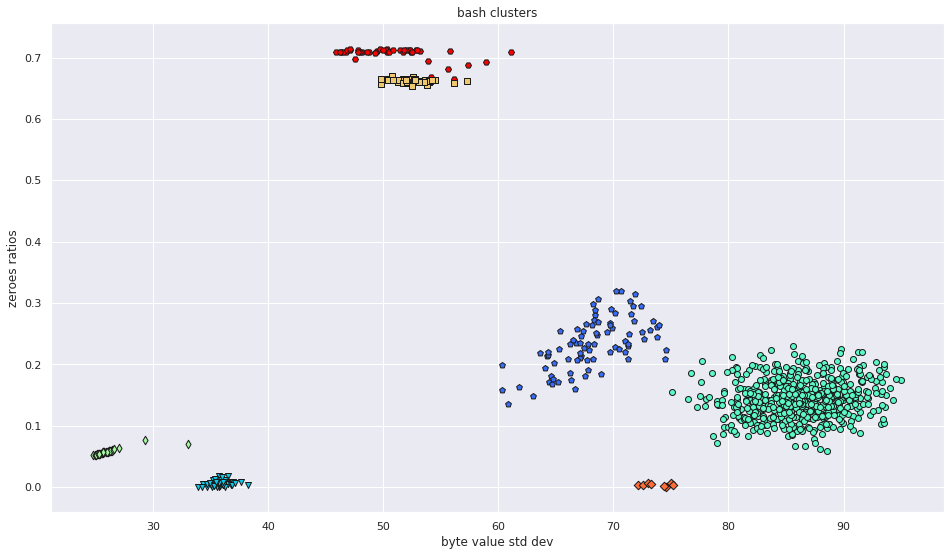

In [17]:
bash.plot_two_features_with_cluster_labels("byte value std dev", "zeroes ratios", with_noise=False)

Information in clusters can also be visualized as seperate univariate distributions using box plots or CDF plots (cluster 4 is machine code. Currently the colors in the univariate cluster plots don't match the colors in the 2D cluster plots):

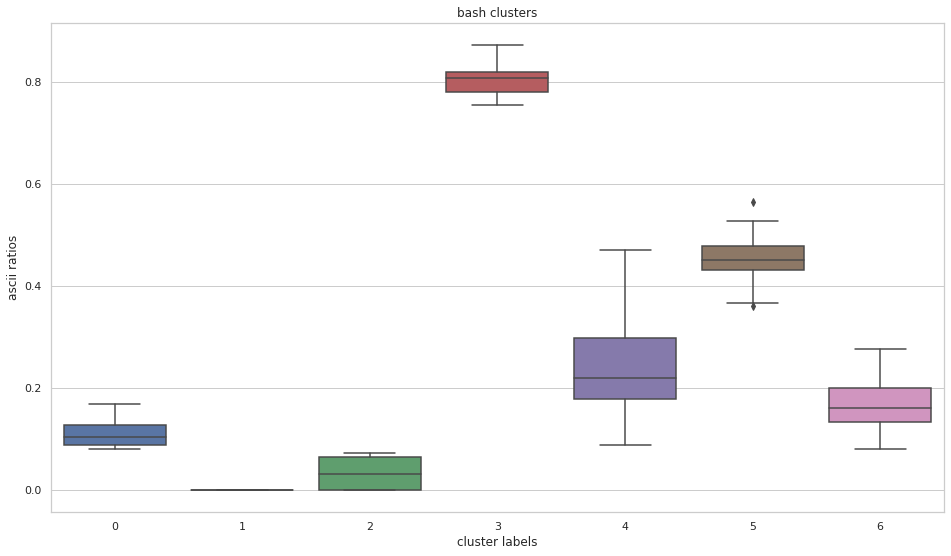

In [18]:
bash.boxplot_cluster_by_feature("ascii ratios")

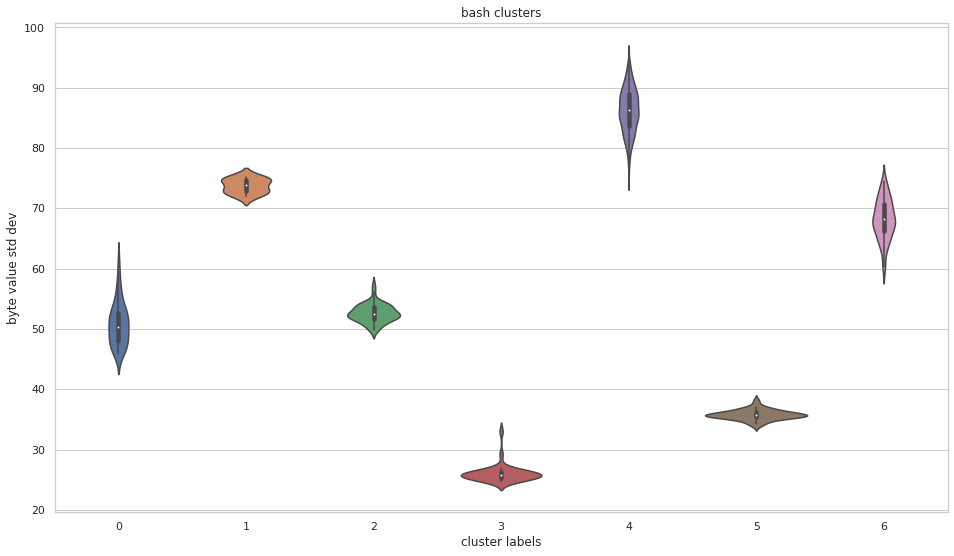

In [19]:
bash.violinplot_cluster_by_feature("byte value std dev")

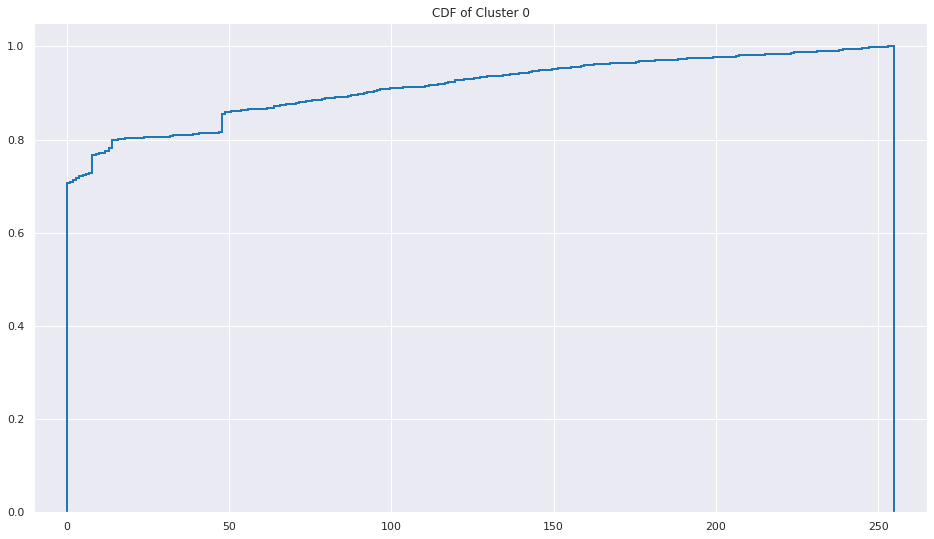

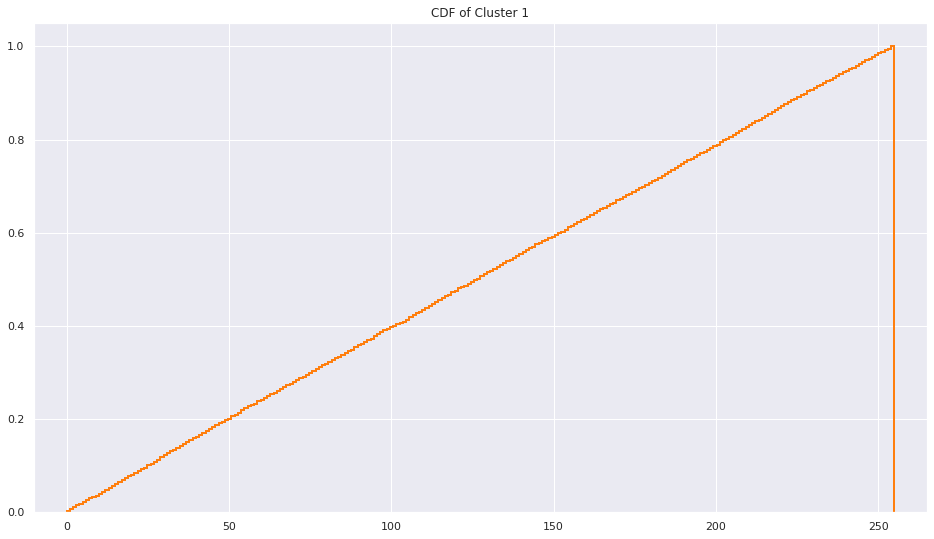

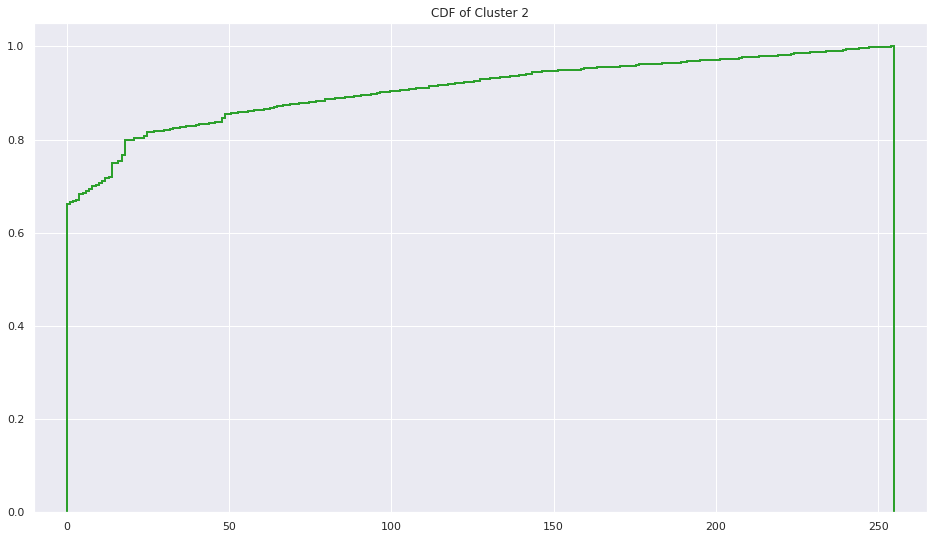

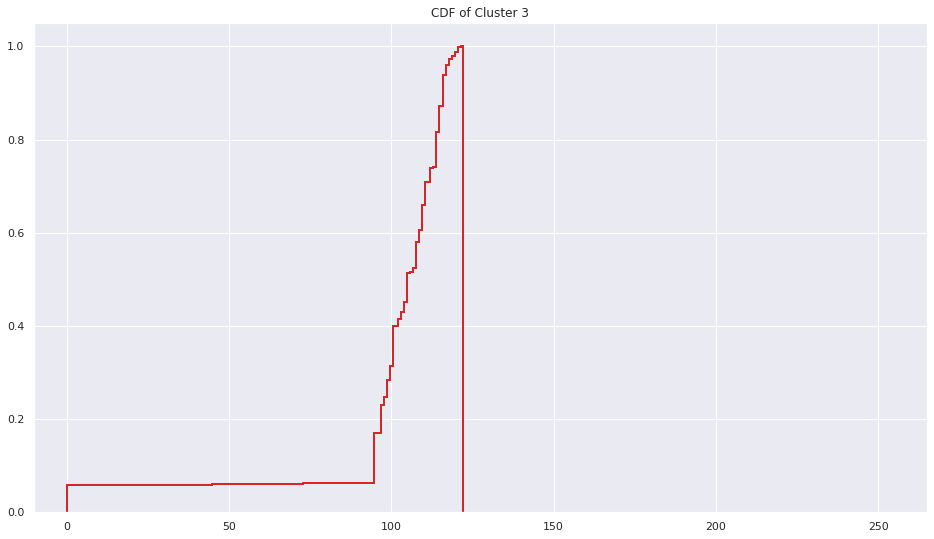

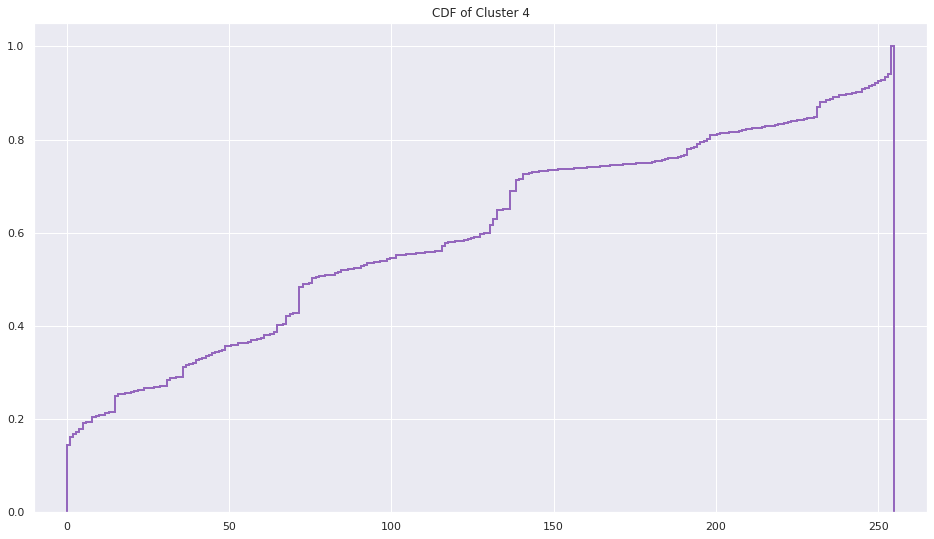

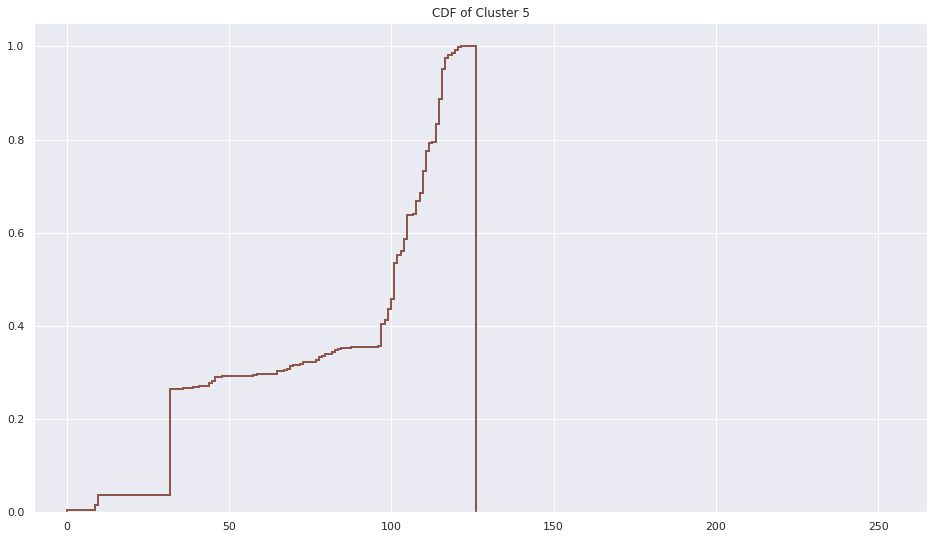

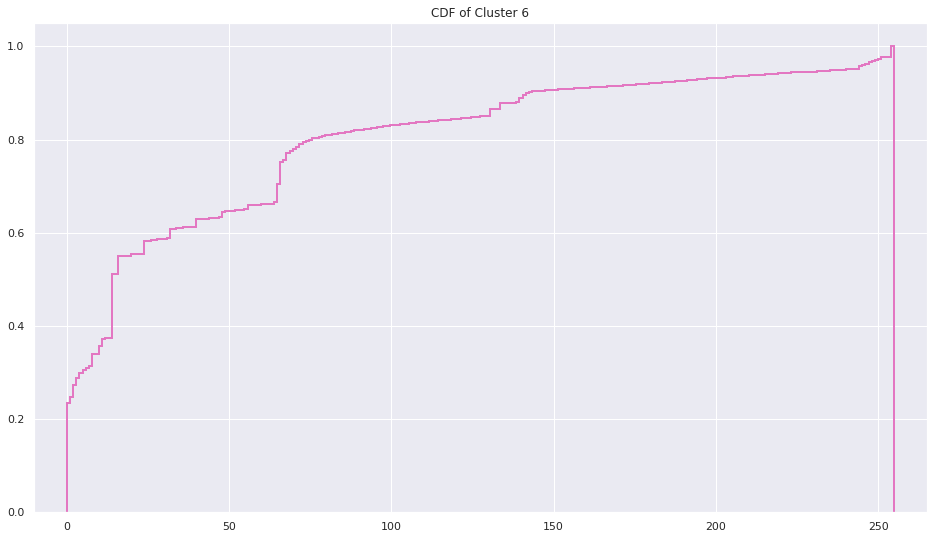

In [20]:
bash.plot_cluster_cdfs()

In addition to visual exploration of the clustering results, it is also possible to analyze cluster properties with statistical methods or using other machine learning algorithms.

<h2>3. Data Type Identification using Wasserstein Distance</h2>

Different types of data have distributions that are often unique enough to distinguish them from other types of data. For example, the distribution of byte values of a cluster consisting of null-terminated ASCII strings differs substantially from the distribution of byte values of a cluster of encrypted data. This means that if reference distributions exist for these data types, data in clusters can be identified by comparing their distributions to the set of data type reference distributions. The [Wasserstein metric](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html) is one way of determining how similar 2 distributions are:

> This distance is also known as the earth mover’s distance, since it can be seen as the minimum amount of “work” required to transform *u* into *v*, where “work” is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved. [10]

Once clusters have been identified within file data, their distributions can be compared to reference distributions:

<img src="https://raw.githubusercontent.com/BinaryResearch/centrifuge-toolkit/master/images/approach_3.png?token=AM7X627EM2OEPU5WRTU4JJK7ILKFU" />

We can see this in action below:

In [21]:
results = bash.identify_cluster_data_types()

Searching for machine code
--------------------------------------------------------------------

[+] Checking Cluster 4 for possible match
[+] Closely matching CPU architecture reference(s) found for Cluster 4
[+] Sending sample to https://isadetect.com/
[+] response:

{
    "prediction": {
        "architecture": "amd64",
        "endianness": "little",
        "wordsize": 64
    },
    "prediction_probability": 1.0
}


Searching for utf8-english data
-------------------------------------------------------------------

[+] UTF-8 (english) detected in Cluster 3
    Wasserstein distance to reference: 16.337275669642857

[+] UTF-8 (english) detected in Cluster 5
    Wasserstein distance to reference: 11.878225097656252


Searching for high entropy data
-------------------------------------------------------------------

[+] High entropy data found in Cluster 1
    Wasserstein distance to reference: 0.48854199218749983
[*] This distance suggests the data in this cluster could be
    a) en

Looking over this output from Centrifuge, we can see a few things:

 - The distribution of Cluster 4 is stated to be a close match to at least one CPU architecture reference distribution.
   - As a result, Centrifuge uses [ISAdetect](https://github.com/kairis/isadetect)'s web API to identify the target architecture of the code in the cluster
 - Clusters 3 and 5 are identified as UTF-8 english data
 - Cluster 1 is identified as containing data that is very close to random
 
 These results can be manually verified in a number of ways. The easiest way to verify that clusters 3 and 5 do in fact consist of text data is to inspect them directly. This can be done by extracting the clusters and dumping them as bytes:

In [22]:
cluster_dataframes, cluster_byte_values = bash.extract_clusters()

In [23]:
# cluster 3 ______________
#                         |
#                         V 
bytes(cluster_byte_values[3])[:1000]

b'fprintf_chk\x00mblen\x00iconv\x00fdopen\x00qsort\x00iconv_open\x00tcgetattr\x00__ctype_toupper_loc\x00__strcpy_chk\x00__ctype_tolower_loc\x00__cxa_finalize\x00freeaddrinfo\x00setvbuf\x00wcscoll\x00fcntl\x00__sprintf_chk\x00wcsdup\x00__xstat\x00getrlimit\x00getdtablesize\x00wmemchr\x00memmove\x00endservent\x00bindtextdomain\x00wcsrtombs\x00setgid\x00faccessat\x00__asprintf_chk\x00tcgetpgrp\x00__libc_start_main\x00setpwent\x00ferror\x00stpcpy\x00wcslen\x00strcoll\x00wcsncmp\x00__strtoul_internal\x00sysconf\x00getservent\x00wctomb\x00__environ\x00sigwinch_sighandler\x00sh_modcase\x00parse_shellopts\x00parse_string\x00_rl_set_normal_color\x00protected_mode\x00rl_show_char\x00rl_byte_oriented\x00__libc_csu_fini\x00rl_filename_quoting_desired\x00search_for_command\x00_rl_eof_char\x00xdupmbstowcs\x00_rl_start_using_history\x00shell_glob_filename\x00_rl_intr_char\x00sourcenest_max\x00rl_outstream\x00sh_get_env_value\x00uitos\x00clean_itemlist\x00rl_discard_keymap\x00alloc_pipeline_saver\x00r

The strings in this cluster are names of dynamically-linked library functions. Turns out cluster 3 captured the strings in the `.dynstr` section of the binary.

In [24]:
# cluster 5 ______________
#                         |
#                         V
bytes(cluster_byte_values[5])[:1000]

b" %s: NULL COMPSPEC\x00%s: cannot allocate %lu bytes\x00xmalloc\x00xrealloc\x00\x00\x00\x00\x00\x00\x00Read lines from a file into an array variable.\n    \n    A synonym for `mapfile'.\x00\x00\x00\x00\x00\x00\x00\x00Read lines from the standard input into an indexed array variable.\n    \n    Read lines from the standard input into the indexed array variable ARRAY, or\n    from file descriptor FD if the -u option is supplied.  The variable MAPFILE\n    is the default ARRAY.\n    \n    Options:\n      -d delim\tUse DELIM to terminate lines, instead of newline\n      -n count\tCopy at most COUNT lines.  If COUNT is 0, all lines are copied\n      -O origin\tBegin assigning to ARRAY at index ORIGIN.  The default index is 0\n      -s count\tDiscard the first COUNT lines read\n      -t\tRemove a trailing DELIM from each line read (default newline)\n      -u fd\tRead lines from file descriptor FD instead of the standard input\n      -C callback\tEvaluate CALLBACK each time QUANTUM lines are

The strings here pertain to command line options, so these are from the `.rodata` section.

The statistical properties of the way these 2 different sets of strings are encoded result in them being assigned different cluster labels. The differences can be seen in the CDF plots above.

Regarding the cluster identified as encrypted data, a byte value frequency histogram can help us determine whether it is truly encrypted or compressed:

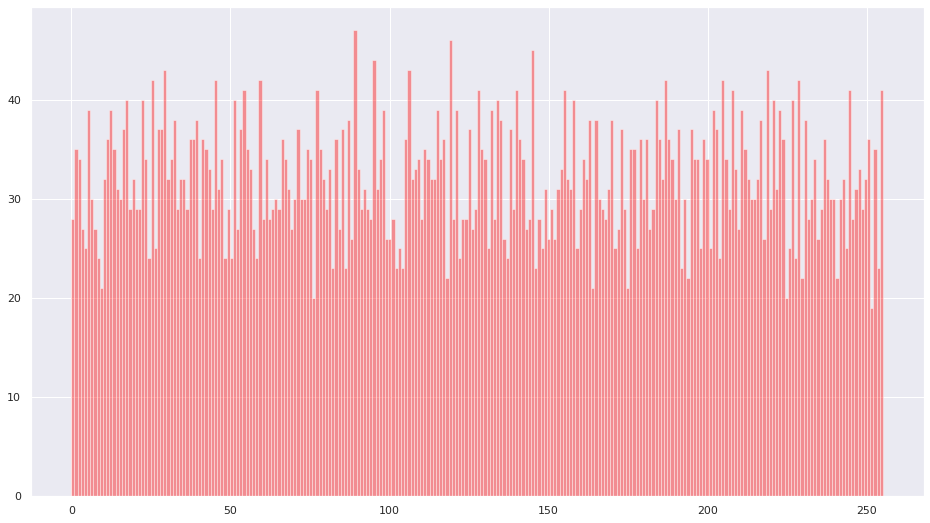

In [25]:
sns.distplot(cluster_byte_values[1], kde=False, bins=256, color="red")

This looks like a random distribution, so we can have confidence that it is encrypted, or at the very least compressed.

If we want to see the Wasserstein distances between every cluster and data type reference distribution, we can look at the data returned by the `identify_cluster_data_types()` function called above.

In [26]:
results

{'machine code': [{'Cluster 0': 76.05282650000001,
   'Cluster 1': 29.328783328342016,
   'Cluster 2': 74.73338515575398,
   'Cluster 3': 63.37747404365079,
   'Cluster 4': [6.982132236915825,
    {'MIPS64EL_reference': 17.566747000518244,
     'PowerPC_reference': 17.095427698072136,
     'i386_reference': 7.08391648935013,
     'ARMEL_reference': 18.338442670864435,
     'MIPSEL_reference': 28.443550522776736,
     'PPC64_reference': 4.714281880467456,
     'AMD64_reference': 2.9711139724036055,
     'ARM64_reference': 7.375978165073073,
     'SH4_reference': 5.57159700925062}],
   'Cluster 5': 47.8965908649631,
   'Cluster 6': 48.04006790718006},
  {'prediction': {'wordsize': 64,
    'endianness': 'little',
    'architecture': 'amd64'},
   'prediction_probability': 1.0}],
 'utf8_en': {'Cluster 0': 70.37821006944444,
  'Cluster 1': 45.723934570312494,
  'Cluster 2': 70.23117873086734,
  'Cluster 3': 16.337275669642857,
  'Cluster 4': 47.547164140236326,
  'Cluster 5': 11.878225097656

<h1>5. Machine Code Target Architecture Identification with Kairajärvi et. al.'s ISAdetect</h1>

Determining the target architecture of a blob of machine code is more or less a solved problem. Using machine learning to do this has been refined over time and resulted in the approach implemented by ISAdetect, which in general is fast and quite accurate.

While measuring Wasserstein distances between machine code clusters and CPU architecture reference distributions is often good enough to correctly identify the target CPU of the machine code, this approach is not consistently accurate for a few reasons:
  - at times, code targeting different CPU families are very similar, so differentiating between them using the Wasserstein metric and reference distributions can lead to misclassification. For example, ARM64 code appears to be quite similar to AVR machine code.
  - related to this, the distance between some reference distributions is quite small. An example is the Wasserstein distance between the i386 and AMD64 reference distributions: only ~6.04.
  - for some architectures, the distribution of byte values in machine code can vary wildly across files.
  
  
As a result, the approach implemented by Centrifuge w.r.t. identifying machine code and its target architecture involves 3 steps:
 1. Firstly, only clusters falling within a specific entropy range are considered for further analysis. Machine code entropy level is fairly consistent across architectures.
 2. Should a cluster fall within this range, its distribution is checked against all CPU architecture reference distributions.
 3. If a close match is found (at time of writing, a Wasserstein distance of less than 10), the cluster is likely to contain machine code and the raw bytes are sent to the ISAdetect server for analysis.
 
Steps must be taken to ensure the data analyzed by ISAdetect truly is machine code because ISAdetect assumes all input is either a code fragment or a file containing code. For example, if a JPG file is uploaded via the web API, you will still get a CPU architecture prediction.


<hr>

<h1>References</h1>

1. Costin, A., Zarras, A., & Francillon, A. (2017). Towards Automated Classification of Firmware Images and Identification of Embedded Devices. In S. De Capitani di Vimercati, & F. Martinelli (Eds.), ICT Systems Security and Privacy Protection : 32ndIFIP TC 11 International Conference, SEC 2017, Rome, Italy, May 29-31, 2017, Proceedings (pp. 233-247). IFIP Advances in Information and Communication Technology, 502. Cham: Springer. doi:10.1007/978-3-319-58469-0_16 (http://s3.eurecom.fr/docs/ifip17_costin.pdf)
2. John Clemens, Automatic classification of object code using machine learning, Digital Investigation, Volume 14, Supplement 1,
2015, Pages S156-S162, ISSN 1742-2876,
https://doi.org/10.1016/j.diin.2015.05.007.
(http://www.sciencedirect.com/science/article/pii/S1742287615000523)
3. Moody, Sarah Jean, "Automated Data Type Identification And Localization Using Statistical Analysis Data Identification" (2008). All Graduate Theses and Dissertations. 9. https://digitalcommons.usu.edu/etd/9 (https://digitalcommons.usu.edu/cgi/viewcontent.cgi?referer=&httpsredir=1&article=1009&context=etd)
4. Gregory Conti, Sergey Bratus, Anna Shubina, Benjamin Sangster, Roy Ragsdale, Matthew Supan, Andrew Lichtenberg, Robert Perez-Alemany, Automated mapping of large binary objects using primitive fragment type classification, Digital Investigation, Volume 7, Supplement, 2010, Pages S3-S12, ISSN 1742-2876,
https://doi.org/10.1016/j.diin.2010.05.002.
(http://www.sciencedirect.com/science/article/pii/S1742287610000290)
5. Sickendick, Karl A. “File Carving and Malware Identification Algorithms Applied to Firmware Reverse Engineering.” (2013). (https://apps.dtic.mil/dtic/tr/fulltext/u2/a576153.pdf)
6. Granboulan, Louise. "cpu_rec.py, un outil statistique pour la reconnaissance d'architectures binaires exotiques". SSTIC2017.  (https://www.sstic.org/media/SSTIC2017/SSTIC-actes/cpu_rec/SSTIC2017-Article-cpu_rec-granboulan.pdf)
English translation:(https://github.com/airbus-seclab/cpu_rec/blob/master/doc/cpu_rec_sstic_english.md)
github repo: https://github.com/airbus-seclab/cpu_rec/
7. binwalk. https://github.com/ReFirmLabs/binwalk
8. [2.3. Clustering](https://scikit-learn.org/stable/modules/clustering.html#dbscan)
9. [sklearn.cluster.DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)
10. [scipy.stats.wasserstein_distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html)
11. Sami Kairajärvi, Andrei Costin, Timo Hämäläinen. [Towards usable automated detection of CPU architecture and endianness for arbitrary binary files and object code sequences](https://arxiv.org/abs/1908.05459). 2019.

<h1>Python Libraries</h1>

 - Pauli Virtanen, Ralf Gommers, Travis E. Oliphant, Matt Haberland, Tyler Reddy, David Cournapeau, Evgeni Burovski, Pearu Peterson, Warren Weckesser, Jonathan Bright, Stéfan J. van der Walt, Matthew Brett, Joshua Wilson, K. Jarrod Millman, Nikolay Mayorov, Andrew R. J. Nelson, Eric Jones, Robert Kern, Eric Larson, CJ Carey, İlhan Polat, Yu Feng, Eric W. Moore, Jake VanderPlas, Denis Laxalde, Josef Perktold, Robert Cimrman, Ian Henriksen, E.A. Quintero, Charles R Harris, Anne M. Archibald, Antônio H. Ribeiro, Fabian Pedregosa, Paul van Mulbregt, and SciPy 1.0 Contributors. (2020) SciPy 1.0: Fundamental Algorithms for Scientific Computing in Python. Nature Methods, in press.
 - Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30 (2011), DOI:10.1109/MCSE.2011.37 
 - John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55 
 - Wes McKinney. Data Structures for Statistical Computing in Python, Proceedings of the 9th Python in Science Conference, 51-56 (2010)
 - Fabian Pedregosa, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, Peter Prettenhofer, Ron Weiss, Vincent Dubourg, Jake Vanderplas, Alexandre Passos, David Cournapeau, Matthieu Brucher, Matthieu Perrot, Édouard Duchesnay. Scikit-learn: Machine Learning in Python, Journal of Machine Learning Research, 12, 2825-2830 (2011)

<hr>

Created by Julian Daeumer